In [1]:
# Import libs
from sklearn.preprocessing import MinMaxScaler, StandardScaler, KBinsDiscretizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn import metrics
from numpy import ndarray
import time
import pandas as pd
from numpy import mean
from numpy import std
from math import sqrt
import numpy as np
import math

# Load pickle
from parseit.data import load_pickle
pickle_with_nb_features = load_pickle(f"comments-bows.p")

<AxesSubplot:>

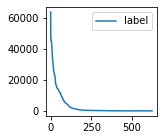

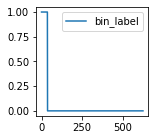

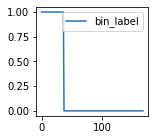

In [7]:
# Bin data here

# ideas:
# Drop indexs more from lower score and less from higher score [IMPLEMENTED!]
# https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset/28557333#28557333
# https://stats.stackexchange.com/questions/99667/naive-bayes-with-unbalanced-classes

df = pickle_with_nb_features.copy()

# TODO: bows and tf-idf contains a word "label"
# Define y and X
y = df[["label"]]
X = df.drop(["body", "submission", "subreddit", "label"], axis=1)

# Show distribution of all data before we bin
label_sorted = y[["label"]].sort_values("label", ascending=False).reset_index().drop("index", axis=1)
label_sorted.plot.line(figsize=(2,2))

# Chose bins and qr
bins = 2
qr = 3

# uniform = All bins in each feature have identical widths.
# quantile = All bins in each feature have the same number of points.
# kmeans = Values in each bin have the same nearest center of a 1D k-means cluster.
#   kmeans seems right: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization_strategies.html
est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy="kmeans") # for a total_bins = 4, create binned data of 2 and 4
est.fit(y)
yt:ndarray = est.transform(y)
y_binned = pd.DataFrame(data=yt, columns=["bin_label"])
X_binned = X

bin_label_sorted = y_binned.sort_values("bin_label", ascending=False).reset_index().drop("index", axis=1)
bin_label_sorted.plot.line(figsize=(2,2))

# We have so skewed data, so maybe we can drop off a few comments from the first large bins so that
# the distribution of comments in each bin are more even

# do this to shrink the size of each bin to have a max size of its quantile propotion; 
# if doing it repeatedly, the size of the entire sample shrinks so the quantile for each bin shrinks yet again
for x in range(qr): 
    for b in range(bins):
        # check the proportion of a bin, i.e. the first bin might be 70%
        bin_proportion = len(y_binned[y_binned.bin_label == b]) / len(y_binned)
        # if there are five bins, no bin should be above 20% (which is one 5th or 1/5)
        # so if the bin is 70% of the entire sample, drop 50% so that the bin is only 20% max
        number_to_drop = math.floor((bin_proportion - 1/bins) * len(y_binned[y_binned.bin_label == b]))
        if number_to_drop > 0:
            indexes_to_drop = y_binned[y_binned.bin_label == b][:number_to_drop]
            y_binned = y_binned.drop(index=indexes_to_drop.index)
            X_binned = X_binned.drop(index=indexes_to_drop.index)

bin_label_sorted = y_binned.sort_values("bin_label", ascending=False).reset_index().drop("index", axis=1)
bin_label_sorted.plot.line(figsize=(2,2))

# The first graph shows the distribution of of the labels, unbinned

# The second shows what happens when we bin the data with kmeans algorithm
# The third one shows what happens when we try to quantile the bins after a kmeans distribution (we see that we dropped of a lot of comments)

# The 4th, 6th, 8th, etc shows the same as the 2nd
# The 5th, 7th, 9th, etc shows the same as the third.


80.35714285714286% 45 correct guesses of 56 in split:1
85.71428571428571% 48 correct guesses of 56 in split:2
87.5% 49 correct guesses of 56 in split:3

Avarage accuracy for all splits (manually calculated): 84.52380952380952%

Accuracy: 84.52380952380952% (142 comments of 168)
Balanced accuracy: 65.95855694692904%


Graphs below shows predicted value vs true value. One graph per split.


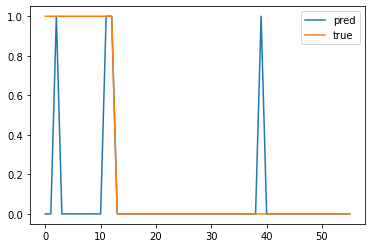

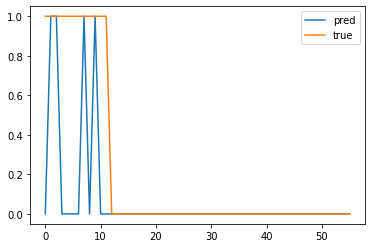

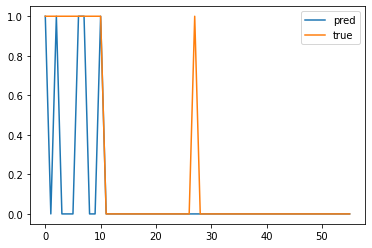

In [12]:

# ML here

# copy the binned y and X
yb = y_binned.copy()
Xb = X_binned.copy()

#display(yb)
splits = 3

true_values = []
pred_values = []
manual_accuracy = []
accuracies = np.array([])
balanced_accuracies = np.array([])

# https://stats.stackexchange.com/questions/131255/class-imbalance-in-supervised-machine-learning
# https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification/32820#32820
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
split = 1
skf = StratifiedKFold(n_splits=splits, random_state=42, shuffle=True)
for train_index, test_index in skf.split(Xb, yb):
    
    # fetch the train and validate k folds from Xb and yb
    X_train, X_validate = Xb.iloc[train_index], Xb.iloc[test_index]
    y_train, y_validate = yb.iloc[train_index], yb.iloc[test_index]

    # scale data
    scaler = MinMaxScaler() #
    scaler.fit(X_train, y_train) # Don't cheat: fit only training data. y is ignored, but still needs same shape
    
    # Model
    model = MultinomialNB()
    model.fit(scaler.transform(X_train), y_train) # Train the model using the training sets - scale only features (?)
    y_pred = model.predict(scaler.transform(X_validate)) # Predic the validation set
    accuracy = metrics.accuracy_score(y_validate, y_pred, normalize=True) # check the accuracy
    balanced_accuracy = metrics.balanced_accuracy_score(y_validate, y_pred, adjusted=False) # check the balanced accuracy
    # TODO: balanced - stackoverflow.com/questions/55838262/why-does-cross-validation-give-consistently-higher-scores-than-normal-fitting-an
    # TODO: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html

    y_valid = y_validate["bin_label"].tolist()

    cor = 0
    for i in range(len(y_pred)):
        cor = cor+1 if y_pred[i] == y_valid[i] else cor

    print(f"{(cor/len(y_pred))*100}% {cor} correct guesses of {len(y_pred)} in split:{split}")
    results = pd.DataFrame({"pred": y_pred, "true": y_valid})
    #display(results)
    results.plot()

    manual_accuracy.append(cor/len(y_pred))
    true_values.append(y_valid)
    pred_values.append(y_pred)
    accuracies = np.append(accuracies, accuracy)
    balanced_accuracies = np.append(balanced_accuracies, balanced_accuracy)
    split = split+1


print(f"\nAvarage accuracy for all splits (manually calculated): {(sum(manual_accuracy)/splits)*100}%")

#print(f'Accuracy: {"%.2f" % (accuracy_norm * 100)}% ({accuracy} comments of {math.floor(len(y.index)*test_size)}) for k={kk}')
print(f"\nAccuracy: {(np.mean(accuracies) * 100)}% ({math.floor(np.mean(accuracies)*len(yb))} comments of {len(yb)})")
print(f"Balanced accuracy: {(np.mean(balanced_accuracies) * 100)}%")

print("\n\nGraphs below shows predicted value vs true value. One graph per split.")
